In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os,errno
import sys
import pandas as pd
%matplotlib inline

dir2='/thorncroftlab_rit/ahenny/rain/'
dir1='/thorncroftlab_rit/ahenny/rain/US/ghcnd_all/'
dir='/thorncroftlab_rit/ahenny/rain/DISSERTATION_SCRIPTS_RESULTS/'
#This script plots seasonal frequency and individual precipitation of EP days

In [4]:
#@author: Michael Schramm on GitHub
#This function is derived from code originally posted by Sat Kumar Tomer
#(satkumartomer@gmail.com)
#See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

from scipy.stats import norm
import scipy.stats as st
def mk_test(x, alpha=0.05):
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [19]:
yrs_taiwan=np.arange(1979,2020,1)
if 1==0:#first - Taiwan line plots of EP day total rainfall
    ds=xr.open_dataset(dir+'ls_extreme_rain_taiwan.nc')
    p=ds['large_scale_extreme_rain_all']
    dates=ds.large_scale_extreme_days
    p_mean=p.mean(dim=('lat','lon'),skipna=True).values.tolist()
    dates_pd=pd.DatetimeIndex(dates.values)
    years=dates_pd.year
    years=years.values.tolist()
    print(len(years))
    
    zipped=list(zip(years,p_mean))
    values_list=[]
    freqs_list=[]
    for i in range(len(yrs_taiwan)):
        year=yrs_taiwan[0]+i
        select_year=[x for x in zipped if x[0]==year]
        means_year=[x[1] for x in select_year]
        if len(means_year)>1:
            total_year=sum(means_year)*30./47.
        elif len(means_year)==1:
            total_year=means_year[0]*30./47.
        else:
            total_year=0
        values_list.append(total_year)
        freqs_list.append(len(select_year))

    
    import scipy.stats as st
    line_all=st.linregress(years,p_mean)
    line_freq=st.linregress(yrs_taiwan,freqs_list)
    mk1=mk_test(freqs_list,alpha=0.05)
    if mk1[0] in ['increasing','decreasing']:
        mk1_str='MK-test = significant'
    else:
        mk1_str='MK-test = insignificant'
        
    if line_all[3]<=0.05:
        line_all_str='Lin-reg = significant'
    else:
        line_all_str='Lin-reg = insignificant'
        
    if mk1[0] in ['increasing','decreasing']:
        line_freq_str='Lin-reg = significant'
    else:
        line_freq_str='Lin-reg = insignificant'
    
    if line_freq[1]<0:
        eq_1='y='+str(round(line_freq[0],2))+'x-'+str(round(abs(line_freq[1]),2))+', p='+str(round(line_freq[3],4))
    else:
        eq_1='y='+str(round(line_freq[0],2))+'x+'+str(round(line_freq[1],2))+', p='+str(round(line_freq[3],4))
        
    if line_all[1]<0:
        eq_2='y='+str(round(line_all[0],2))+'x-'+str(round(abs(line_all[1]),2))+', p='+str(round(line_all[3],4))
    else:
        eq_2='y='+str(round(line_all[0],2))+'x+'+str(round(line_all[1],2))+', p='+str(round(line_all[3],4))
        
    label_2='EP day frequency ('+eq_1+') | '+mk1_str
    label_1='EP day precip ('+eq_2+') | '+line_all_str

79


In [4]:
fig.savefig(dir+'taiwan_ep_define_line_plot.png')

197.035400390625


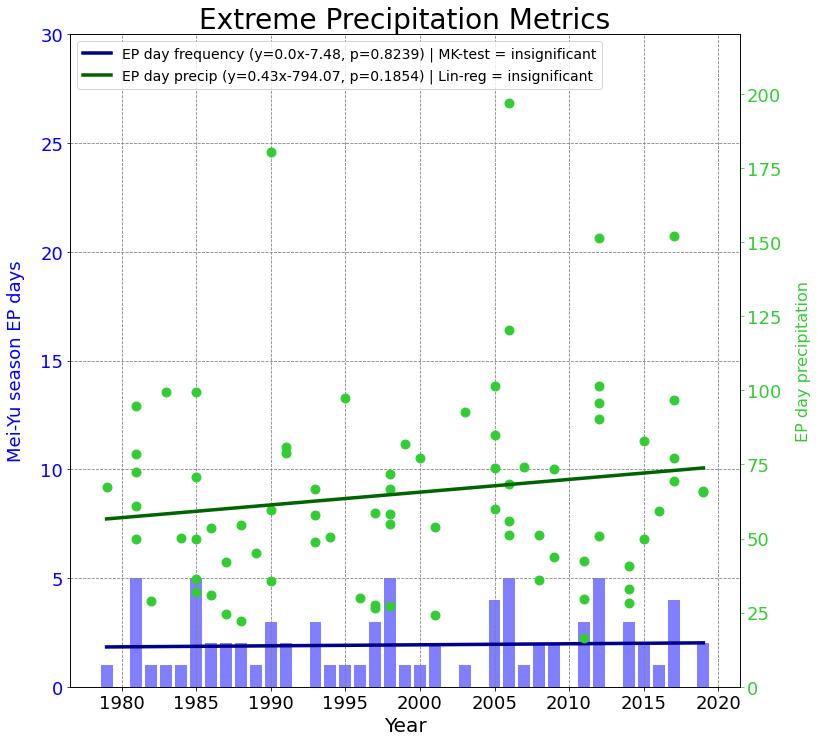

In [20]:
fig=plt.figure(figsize=(12,12))
ax=plt.subplot(1,1,1)
ax.tick_params(labelsize=18)
ax.set_title('Extreme Precipitation Metrics',fontsize=28)
ax.set_ylabel('Mei-Yu season EP days',labelpad=15,color='b',fontsize=18)
ax.bar(yrs_taiwan,freqs_list,color='b',alpha=0.5)
print(max(p_mean))
#plt.xticks(rotation=75)
plt.grid(True,color='grey',linestyle='--')
ax.set_ylim(0,30)
ax.set_xlabel('Year',fontsize=20)
ax.tick_params(axis='y',color='b')
plt.setp(ax.get_yticklabels(), color='b')
lns1=ax.plot(yrs_taiwan,[x*line_freq[0]+line_freq[1] for x in yrs_taiwan],color='darkblue',linewidth=3.5,label=label_2)
ax1=ax.twinx()
#ax1.plot(yrs,intensity_year_list,color='g',linewidth=2.0,label='Mean EP day intensity')
ax1.scatter(years,p_mean,c='limegreen',s=80)
lns2=ax1.plot(yrs_taiwan,[x*line_all[0]+line_all[1] for x in yrs_taiwan],color='darkgreen',linewidth=3.5,label=label_1)
ax1.set_ylim(0,220)
ax1.tick_params(labelsize=18)
lns=lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left',fontsize=14)
ax1.tick_params(axis='y',color='limegreen')
plt.setp(ax1.get_yticklabels(), color='limegreen')
ax1.set_ylabel('EP day precipitation',labelpad=15,color='limegreen',fontsize=16)
plt.show()

In [21]:
fig.savefig(dir+'taiwan_wtype_paper_results1.png')